In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
from torch import nn
import matplotlib.pyplot as plt

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcaase this, let's creat some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**

In [5]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [6]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

Let's create a training and test set with our data
---



In [7]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

In [8]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot testing data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  # Are there predictions
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(prop={'size': 14})

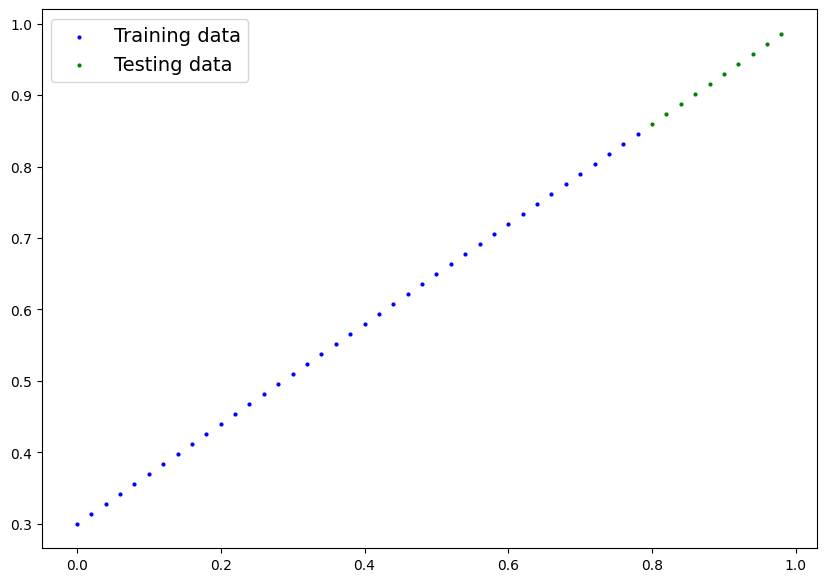

In [9]:
plot_predictions()

## 2. Build model

What our model does:
* Start with random values for weight and bias
* Look at the training data and adjust the random values to better represent the ideal values

How does it do this?
1. Through gradient descent - https://www.youtube.com/watch?v=sDv4f4s2SB8
2. Backpropogation - https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [10]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.rand(1,
                                        requires_grad=True,
                                        dtype=torch.float))

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias


### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs
* torch.nn.Paramter - what parameters should our model try and learn
* torch.nn.Module - The base class for all neural network modules
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward, this method defines what happens in the forward computation

[PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html)


### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside.
We can check out our model parameters or what's inside our model by using .parameters

In [11]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [12]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.3904]))])

### Making prediction using `torch.inference_mode()`

To check out the model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run it through the `forward()` method.

In [13]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.6598],
        [0.6665],
        [0.6733],
        [0.6800],
        [0.6867],
        [0.6935],
        [0.7002],
        [0.7069],
        [0.7137],
        [0.7204]])

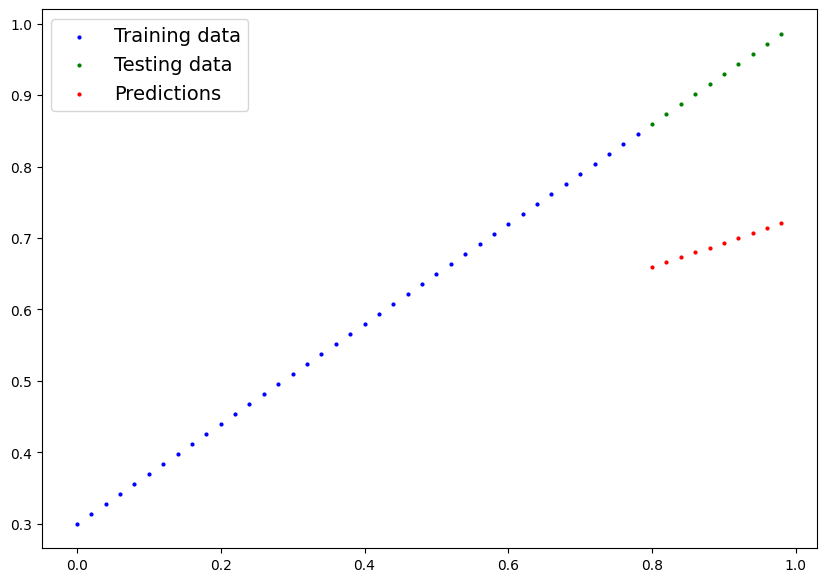

In [14]:
plot_predictions(predictions=y_preds)

## 3. Train a model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words, from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

A loss function may also be called a cost function, or a criterion in different areas.  For this case, we're going to refer to it as a loss function

Things we need to train:

**Loss Function**: A function to measure how wrong the model's predictions are to the ideal output.  Lower values are better.

**Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. the weight and bias) to improve the loss function.
  * Inside the optimizer you'll have to set two parameters
    * `params` - the model parameters you'd like to optimize
    * `lr` - the learning rate of the optimizer

Specifically for PyTorch we need:
* A training loop
* A testing loop

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Building a training and testing loop

Some things we will need
0. Loop through the data
1. Forward pass this involves data moving through the model's `forward()` function
2. Calculate the loss
3. Optimize zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each parameter of the model with respect to the loss (**backpropogation**)
5. Optimizer step - Use the optimizer to adjust the model's parameters to try and improve the loss (**Gradient Descent**)



In [16]:
# An epoch is one loop through the data..
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
for epoch in range(epochs):
  # Set the model the training mode
  model_0.train()

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f'Loss: {loss}')

  # 3. Optimizer zero grad
  optimizer.zero_grad() # If we don't zero the gradient descent, the optimizer accumulates the values

  # 4. Perform backpropogation on the loss with respect to the parameters
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  ## Testing
  model_0.eval()
  with torch.inference_mode():
    test_pred = model_0(X_test)
    test_loss = loss_fn(test_pred, y_test)

  epoch_count.append(epoch)
  loss_values.append(loss.detach().numpy())
  test_loss_values.append(test_loss)

  print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.08169572055339813 | Test loss: 0.22662055492401123
Epoch: 1 | Loss: 0.07951223105192184 | Test loss: 0.22095942497253418
Epoch: 2 | Loss: 0.07771821320056915 | Test loss: 0.21529832482337952
Epoch: 3 | Loss: 0.07596267759799957 | Test loss: 0.21026185154914856
Epoch: 4 | Loss: 0.07452543079853058 | Test loss: 0.20522534847259521
Epoch: 5 | Loss: 0.07310795783996582 | Test loss: 0.2008223533630371
Epoch: 6 | Loss: 0.07197895646095276 | Test loss: 0.196419358253479
Epoch: 7 | Loss: 0.0708499550819397 | Test loss: 0.1920163482427597
Epoch: 8 | Loss: 0.0698218122124672 | Test loss: 0.18825574219226837
Epoch: 9 | Loss: 0.06895165145397186 | Test loss: 0.18449512124061584
Epoch: 10 | Loss: 0.06808149069547653 | Test loss: 0.1807345449924469
Epoch: 11 | Loss: 0.06732632219791412 | Test loss: 0.17762522399425507
Epoch: 12 | Loss: 0.06666463613510132 | Test loss: 0.174515962600708
Epoch: 13 | Loss: 0.06600294262170792 | Test loss: 0.17140667140483856
Epoch: 14 | Loss: 0.06540

In [17]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8634],
        [0.8773],
        [0.8913],
        [0.9052],
        [0.9191],
        [0.9330],
        [0.9469],
        [0.9609],
        [0.9748],
        [0.9887]])

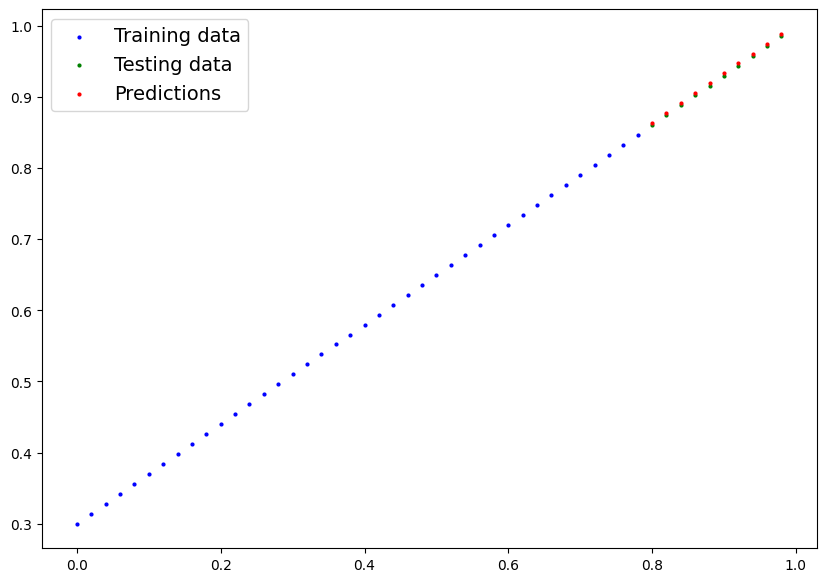

In [18]:
plot_predictions(predictions=y_preds)

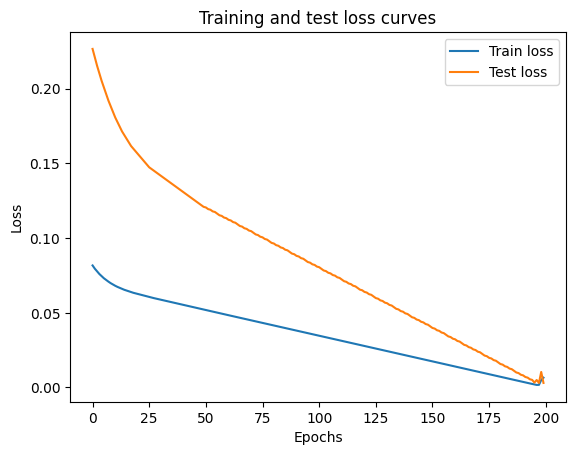

In [19]:
import numpy as np

plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

### Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows the loading of a model's state dictionary.

In [20]:
# Saving our PyTorch model
from pathlib import Path

# Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = '01_pytorch_workflow_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


### Loading a PyTorch model

Since we saved the mode's state dict, rather the endire model, we'll create a new instance of our model's class and load the state_dict() into that.

In [21]:
# To load in a saved state_dict, we have to instantiate a new insta of the model's class

loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-21-53939aeaa4f4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [22]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6962])), ('bias', tensor([0.3064]))])

In [23]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8634],
        [0.8773],
        [0.8913],
        [0.9052],
        [0.9191],
        [0.9330],
        [0.9469],
        [0.9609],
        [0.9748],
        [0.9887]])

## Putting it all together

## Data

In [24]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.4
bias = 0.8

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.8000],
         [0.8080],
         [0.8160],
         [0.8240],
         [0.8320],
         [0.8400],
         [0.8480],
         [0.8560],
         [0.8640],
         [0.8720]]))

In [25]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

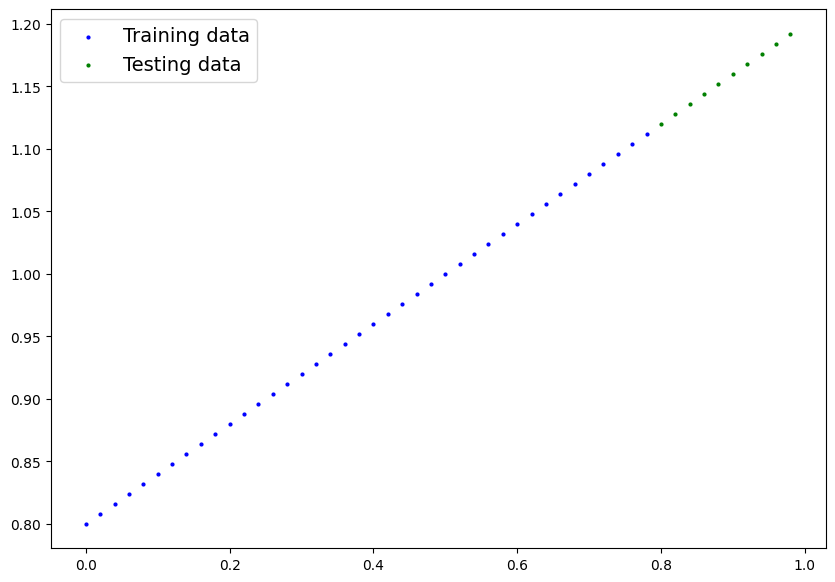

In [26]:
# Plot the data

plot_predictions(X_train, y_train, X_test, y_test)

### Building a PyTorch Linear model

In [27]:
# Create a linear model

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [28]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training

For training we need:
* Loss function
* Optimizer
* Training Loop
* Testing Loop

In [29]:
# Setup loss function
loss_fn = nn.L1Loss() # Same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=.01)

In [36]:
# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [54]:
# Write the training loop
torch.manual_seed(42)

epochs = 300

for epoch in range(epochs):
  model_1.train()
  # Foward Pass
  y_pred = model_1(X_train)

  # Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # Optimizer zero gradient
  optimizer.zero_grad()

  # Back propogation
  loss.backward()

  # optimizer step
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 10 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 20 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 30 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 40 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 50 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 60 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 70 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 80 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 90 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 100 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 110 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 120 | Loss: 0.007591067347675562 | Test loss: 0.0016084194649010897
Epoch: 130 | Loss: 0.007591067347675

In [55]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4085]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8043], device='cuda:0'))])

In [56]:
weight, bias

(0.4, 0.8)